In [56]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import SamplerV2


In [57]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [58]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

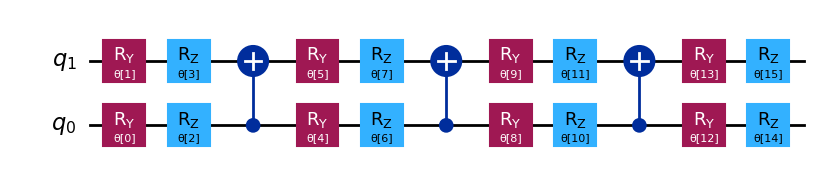

In [59]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [60]:
num_params = ansatz.num_parameters
num_params

16

In [61]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

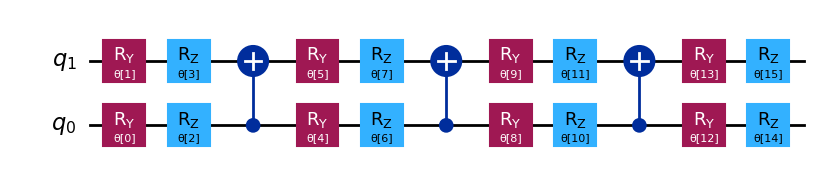

In [62]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [63]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost Function

In [97]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def get_probability_distribution(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

def cost_func(params, ansatz, hamiltonian):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]


    # hamiltonian = SparsePauliOp.from_list(
    # [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)])

    shots = 10000
    energy = 0

    # CLIQUE 1: YZ
    ansatz_1 = ansatz.copy()
    ansatz_1.sdg(0)
    ansatz_1.h(0)
    ansatz_1.measure_all()

    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_1, [params], shots)])
    counts = job.result()[0].data.meas.get_counts()
    output_distribution = get_probability_distribution(counts, sum(counts.values()))
    eigenvalues_YZ = np.kron([1,-1], [1,-1])

    expectation_values_YZ = np.dot(eigenvalues_YZ, output_distribution)
    energy += expectation_values_YZ*0.3980
    

    # CLIQUE 2: ZI, ZZ
    ansatz_2 = ansatz.copy()
    ansatz_2.measure_all()

    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_2, [params], shots)])
    counts = job.result()[0].data.meas.get_counts()
    # print("COUNTS:", counts)
    output_distribution = get_probability_distribution(counts, sum(counts.values()))
    
    eigenvalues_ZI = np.kron([1,-1], [1,1])
    eigenvalues_ZZ = np.kron([1,1], [1,-1])

    expectation_values_ZI = np.dot(eigenvalues_ZI, output_distribution)
    expectation_values_ZZ = np.dot(eigenvalues_ZZ, output_distribution)

    energy += expectation_values_ZI*-0.3980 + expectation_values_ZZ*-0.0113


    # CLIQUE 3: XX
    ansatz_3 = ansatz.copy()
    ansatz_3.h([0,1])
    ansatz_3.measure_all()

    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_3, [params], shots)])
    counts = job.result()[0].data.meas.get_counts()
    # print("COUNTS:", counts)
    output_distribution = get_probability_distribution(counts, sum(counts.values()))
    
    eigenvalues_XX = np.kron([1,-1], [1,-1])
    expectation_values_XX = np.dot(eigenvalues_XX, output_distribution)

    energy += expectation_values_XX*0.1810
    
    

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [98]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122,
       0.12933619, 6.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452])

In [99]:
with Session(backend=backend) as session:
    # estimator = Estimator(session=session)
    # estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.15698628000000003]
Iters. done: 2 [Current cost: -0.2285643]
Iters. done: 3 [Current cost: -0.13043651999999997]
Iters. done: 4 [Current cost: -0.12374456000000003]
Iters. done: 5 [Current cost: -0.08844316000000002]
Iters. done: 6 [Current cost: 0.028423560000000014]
Iters. done: 7 [Current cost: 0.16738462]
Iters. done: 8 [Current cost: -0.3107787]
Iters. done: 9 [Current cost: -0.10208000000000005]
Iters. done: 10 [Current cost: -0.14724937999999999]
Iters. done: 11 [Current cost: -0.6606799400000001]
Iters. done: 12 [Current cost: -0.6165034]
Iters. done: 13 [Current cost: -0.42402384000000004]
Iters. done: 14 [Current cost: -0.47609512]
Iters. done: 15 [Current cost: -0.3813642200000001]
Iters. done: 16 [Current cost: -0.41853517999999995]
Iters. done: 17 [Current cost: -0.75727034]
Iters. done: 18 [Current cost: -0.70686126]
Iters. done: 19 [Current cost: -0.6993794]
Iters. done: 20 [Current cost: -0.7433779600000001]
Iters. done: 21 [Current cost:

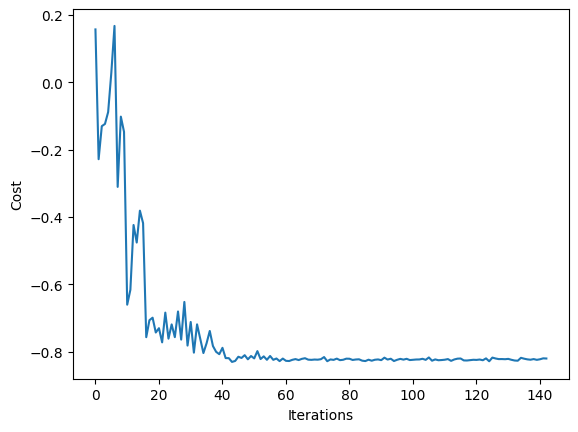

In [100]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()